## Projeto: Transformada de Hilbert-Huang

---

#### Por [Beatriz Coimbra](https://github.com/beatrizmcoimbra) e [Fernanda Scovino](https://github.com/fernandascovino)

Implementação da transformada de Hilbert-Huang para identificação de sons e expansão do [verbete na *Wikipédia*](https://pt.wikipedia.org/wiki/Transformada_de_Hilbert-Huang).


### O que é HHT?

A transformada de Hilbert-Huang é uma técnica adaptativa de decomposição de sinais em tempo-frequência. Esta técnica foi desenvolvida num dos organismos da NASA por Northen E. Huang em 1998, e tem sido aplicada a sinais nos mais variados ramos da ciência, que vão desde a engenharia à medicina.<sup>1</sup> 

#### Qual a sua vantagem?

Em relação aos demais métodos para reconhecimento de pitch (frequência fundamental) de um som, como trasformada de Fourier, é que a transformada HHT toma como input dados e não uma função, é um método empírico e não teórico. 

Além disso, os demais métodos assumem que o processo de produção do som é linear e que os sinais são localmente estacionários (variância e média constantes no tempo) - por causa disso, análises com esses métodos só são possíveis em trechos curtos de tempo, logo o som deve ser trabalhando separadamente em diferentes intervalos, o que prejudica a estimação final. Por outro lado, o método empírico da HHT nos permite analisar sinais não-lineares e não-estacionários!<sup>3</sup>

Ela é realizada em duas etapas: **EMD - Método de decomposição do modo empírico, e HSA - Análise espectral de Hilbert**. 

### O que é EMD?

O método de decomposição do modo empírico (EMD) nos permite decompor sinais (para o som, amplitudes no tempo) em um número finito de componentes mais simples, chamados de funções do modo intrínseco (IMF).<sup>3</sup>

#### O que são IMFs?

Uma função de modo intrínseco é definida como qualquer função que tenha os mesmos, ou diferindo no máximo por um, números de zeros (cruzam o eixo x) e extremos, e também ter "envelopes simétricos" definidos pelos máximos e mínimos locais, respectivamente.<sup>1</sup>. Em qualquer, os dados podem envolver mais de um modo oscilatório, por isso que a transformação simples de Hilbert não pode fornecer a descrição completa do conteúdo de frequência para os dados gerais e é necessária a decomposição em IMFs para identificação dos modos<sup>5</sup>.

O processo de geração das IMFs é chamado de *sifting process*, ou "processo de peneiração", que busca suavizar as amplitudes desiguais. A essência do método é identificar os modos oscilatórios intrínsecos a partir das escalas de tempo dos dados empiricamente, e assim decompor os modos<sup>5</sup>.

As splines cúbicas são utilizadas para traçarmos os envelopes, conectando os máximos/mínimos locais.<sup>2</sup> Vale ressaltar que não existe um embasamento teórico para a utilização da spline em relação a outras técnicas de interpolação, um dos motivos pelo qual o EMD é dito empírico. Adaptações já foram feitas, como a utilização de funções radiais para a interpolação<sup>4</sup>, mas a spline continua sendo a mais difundida.

#### Algoritmo

> 1. Identificação os mínimos e máximos do sinal $x(t)$
> 2. Geração dos envelope superior e inferior de $x(t)$, passando um spline cúbico através dos máximos e mínimos respectivamente
> 3. Cálculo da média dos envelopes superior e inferior como $m(t)$
> 4. Obtenção de um candidato do FMI usando a fórmula  $h_{k}(t) = x(t)−m(t)$ 
> 5. Verificação das propriedades  de uma função do modo intrínseco (IMF) para $h_{k}(t)$
Se $h_{k}(t)$ não é uma IMF, repetimos o processo a partir do passo 1 com $x(t)=h_{k}(t)$. Se for, obtemos o resíduo $r(t) = x(t) - h_{k}(t)$ e repetimos o processo com $x(t) = r(t)$. 

No geral, sendo $h_1(t)$ a 1ª IMF, deve conter o componente de período mais curto do sinal. Como o resíduo contém ainda informação de componentes com período mais longo, refazemos o *sifting* como descrito no passo 5. 

Um critério de parada utilizado para o algoritmo é que o resíduo $r(t)$ se torne uma função monótona.

#### Como identificar uma IMF?

Existem alguns critérios possíveis de serem seguidos, vamos enumerar 2 deles aqui: *Número S* e *Desvio Padrão*. Para fins práticos, utilizaremos o *Número S* como critério.

##### Número S

Este critério baseia-se no chamado número S, que é definido como o número de *siftings* consecutivos para os quais o número de zero crossings e extremos são iguais ou no máximo diferentes por um.

O processo só é interrompido se, para S *siftings* consecutivos, os números de cruzamentos nulos e extremos permanecerem iguais e forem iguais ou no máximo diferentes por um.<sup>1</sup>

##### Desvio padrão 

Foi proposto por Huang et al. (1998). Definimos uma soma das diferenças dos *siftings*, ou desvio padrão, como $SD$ da seguinte forma:

$$SD_{k}=\sum_{{t=0}}^{{T}}{\frac  {|h_{1(k-1)}(t)-h_{1k}(t)|^{2}}{h_{1(k-1)}^{2}(t)}}$$ e estabelecemos um limite para seu tamanho, recomendado no intervalo de 0.2 e 0.3 por Huang et al. (1998).


### O que é HSA?

A análise espectral de Hilbert é utilizada para obtermos a frequência instantânea das IMFs. Porém, primeiro devemos filtrar quais IMFs são relevantes para a análise do sinal e quais representam ruídos, o que pode ser avaliado através de do coeficiente de correlação entre cada IMF e $x(t)$.<sup>7</sup>

Na análise, geramos a função complexa $z_{i}(t)$ utilizando $c_{i}(t) = h_{ik}(t)$ como a parte real e a transformação de Hilbert de $c_{i}(t)$ como a parte imaginária, $d(t) = \frac{1}{\pi \int_{-\infty}^{\infty} \frac{c_{i}(t')}{t-t'} dt}$, obtendo:

$$z_i(t) = c_{i}(t) + jd_{i}(t) = a_{i}(t) e^{j \theta_{i}(t)}$$

 sendo $j = \sqrt{-1}$, $a_{i}(t)$ a **amplitude instantânea** e $\theta_{i}(t)$ a **fase instântanea** da IMF $c_{i}(t)$<sup>3</sup>.
 
 A **frequência instantânea** é obtida a partir da derivação da fase instantânea, ou seja, $\omega_{i}(t) = \frac{d\theta_{i}(t)}{dt}$. Logo, podemos representar os sinais $x(t)$ como:
 
 $$ x(t)  = Re \sum_{i=1}^{n} a_{i}(t)e^{j \int \omega_{i}(t) dt}$$
 

### Referências

1: [Hilbert-Huang transform - Wikipédia](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform)

2: [Spline - Wikipédia](https://pt.wikipedia.org/wiki/Spline)

3: [Speech pitch determination based on Hilbert-Huang transform - Huang, H.; Pan, J. (2006)](https://www.sciencedirect.com/science/article/pii/S0165168405002367)

4: [Bidimensional Empirical Mode Decomposition Modified for Texture Analysis - Nunes, J.C. et all. (2003)](https://pdfs.semanticscholar.org/4cfd/e80b1f8284e35d7544e84172c95a5d7527fd.pdf)

5: [The empirical mode decomposition and the Hilbert spectrum for nonlinear and non-stationary time series analysis - Huang, N. et all. (1998)](http://rspa.royalsocietypublishing.org/content/454/1971/903)

6: [Pitch Detection Method Based on Hilbert-Huang Transform for Erhu Music](http://umir.umac.mo/jspui/handle/123456789/14152)

7: [A Criterion for Selecting Relevant Intrinsic Mode Functions in Empirical Mode Decomposition - AYENU-PRAH, A.; ATTOH-OKINE, N. (2010)](https://www.researchgate.net/publication/220531144_A_Criterion_for_Selecting_Relevant_Intrinsic_Mode_Functions_in_Empirical_Mode_Decomposition)

### Criando os sons 

In [1]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vamos escolher inicialmente a duração das notas como 8000?? para podermos escutar o som. 

Posteriormente, para possibilitar os cálculos, vamos diminuir essa duração.

In [2]:
Fs = 8000
tempo = 8000

In [3]:
def cria_nota(f,Fs,tempo=Fs):
    
    """
    Cria o sinal correspondente à frequência escolhida (nota).
    
    :param f: frequência da nota
    :param Fs: frequência de amostragem
    :param tempo: duração da nota
    """
    
    x = np.arange(tempo)
    y = np.sin(2*np.pi*f*x/Fs)
    
    return y

In [4]:
freq_notas_dic = {
    'do': 261.6,
    'do#': 277,
    're': 293.5,
    're#': 311,
    'mi': 329.6,
    'fa': 349.2,
    'fa#': 370,
    'sol': 392,
    'sol#': 415.1,
    'la': 440,
    'la#': 466.2,
    'si': 493.8
}

In [5]:
def cria_musica(text, Fs, tempo):
    
    """
    Cria a música a partir de uma string de notas.
    
    :param text: string com as notas
    :param Fs: frequência de amostragem
    :param tempo: duração da nota
    """
    
    notas = text.split(',')
    musica = []
    
    for nota in notas:
        
        freq = cria_nota(freq_notas_dic[nota], Fs, tempo)
        musica = np.concatenate((musica, freq),axis=0)
            
    t = len(notas)*tempo
    return t, musica

In [6]:
t, teste = cria_musica('do,fa,mi,re,do,re,do,do,do,re,do,re,mi,fa', Fs, tempo)

In [7]:
sd.play(teste)

In [8]:
t

112000

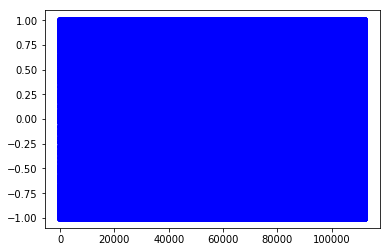

In [9]:
plt.plot(list(range(len(teste))), teste, 'bo')

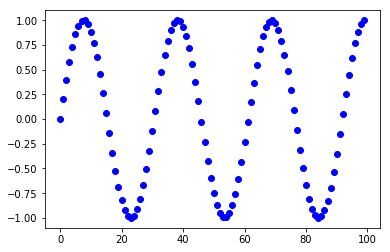

In [10]:
plt.plot(list(range(len(teste[:100]))), teste[:100], 'bo')

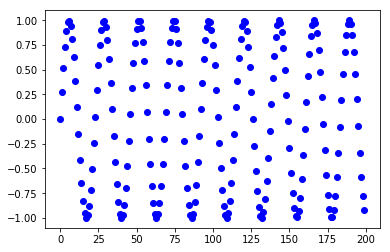

In [11]:
plt.plot(list(range(len(teste[8000:8200]))), teste[8000:8200], 'bo')

### Decompondo os sinais

In [14]:
tempo = 400
t, x = cria_musica('do,fa,mi,re,do,re,do,do,do,re,do,re,mi,fa', tempo, tempo)

In [15]:
t

5600

In [16]:
len(x)

5600

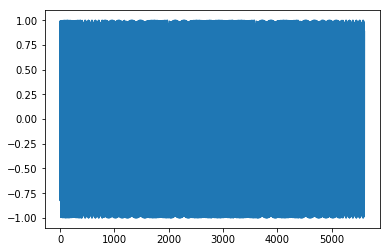

In [17]:
plt.plot(x)

#### 1. Identificando os mínimos e máximos do sinal $x(t)$

In [18]:
from scipy.signal import argrelextrema

In [19]:
def find_extremas(x):
    
    """
    Obtém os máximos e mínimos locais dentre os pontos da função.
    
    :param x: pontos observados da função
    """
    
    # Acha as posições da lista que correspondem aos mínimos e máximos locais
    max_t = argrelextrema(x, np.greater)[0]
    min_t = argrelextrema(x, np.less)[0]
    
    # Acha os valores de máximos e mínimos locais
    max_x = [x[i] for i in max_t]
    min_x = [x[i] for i in min_t]
    
    extremas = [(max_t, min_t), (max_x, min_x)]
    return extremas

In [20]:
x[:10]

array([ 0.        , -0.8235326 ,  0.93432894, -0.236499  , -0.66601187,
        0.9921147 , -0.45957986, -0.47070393,  0.99361131, -0.65658576])

In [21]:
extremos = find_extremas(x)

In [22]:
max_t, min_t = extremos[0]
max_x, min_x = extremos[1]

In [23]:
max_t, min_t

(array([   2,    5,    8, ..., 5576, 5584, 5592]),
 array([   1,    4,    7, ..., 5580, 5588, 5596]))

In [24]:
max_x[:10]

[0.93432894245661202,
 0.99211470131447776,
 0.99361131052000851,
 0.93873385765387429,
 0.830595899195813,
 0.67533280812103036,
 0.48175367410171621,
 0.64705596156944345,
 0.80901699437494246,
 0.92507720683445749]

In [25]:
min_x[:10]

[-0.82353259762842745,
 -0.66601186743425178,
 -0.47070393216533291,
 -0.65658575575295608,
 -0.81633925071718361,
 -0.92977648588824846,
 -0.99046142569665108,
 -0.99495101698130095,
 -0.94299053589286486,
 -0.83752804004214643]

#### 2. Encontrando os envelope superior e inferior de $x(t)$ passando um spline cúbico através dos máximos e mínimos respectivamente

Utilizando o método [`scipy.interpolate.UnivariateSpline`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.UnivariateSpline.html) para a interpolação de spline cúbica:

In [26]:
from scipy.interpolate import UnivariateSpline

In [27]:
def find_envelopes(x, extremos):

    """
    Obtém os envelopes superior e inferior da função (por uma spline cúbica), e a média.
    
    :param x: pontos da função
    :param extremos: retorno da função find_extremas
    """
    
    max_t, min_t = extremos[0]
    max_x, min_x = extremos[1]
    
    # Obtém o envelope superior
    f_max = UnivariateSpline(max_t, max_x, k=3)
    s_max = f_max(max_t)
    
    # Obtém o envelope inferior
    f_min = UnivariateSpline(min_t, min_x, k=3)
    s_min = f_min(min_t)
    
    # Calcula a média dos envelopes
    t = list(range(len(x)))
    m_t = (f_max(t) + f_min(t))/2
    
    return s_max, s_min, m_t

In [28]:
s_max, s_min, m_t = find_envelopes(x, extremos)

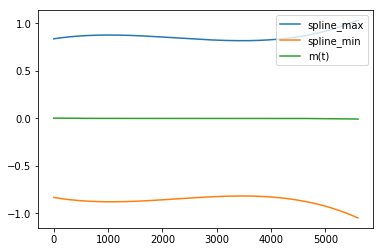

In [29]:
plt.plot(max_t, s_max, label='spline_max')
plt.plot(min_t, s_min, label='spline_min')
plt.plot(m_t, label='m(t)')
plt.legend()

#### 3. Calcule a média dos envelopes superior e inferior como $m(t)$

Calculamos no item anterior, mas aqui demos um zoom:

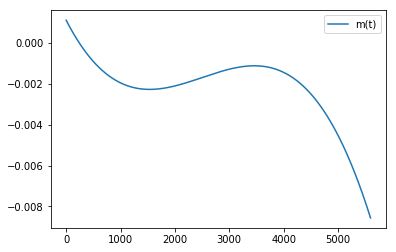

In [30]:
plt.plot(m_t, label='m(t)')
plt.legend()

#### 4. Obter um candidato do FMI usando a fórmula $h_{k}(t) = x(t) - m(t)$

In [31]:
h = x - m_t

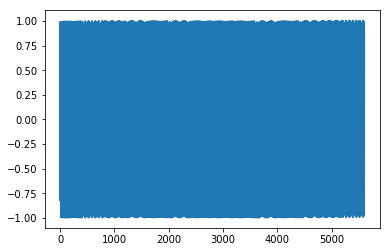

In [32]:
plt.plot(h)

In [33]:
h

array([-0.00110196, -0.8246294 ,  0.9332373 , ..., -0.47870684,
        0.29357097,  0.89379146])

#### 5. Verifique se as propriedades $h_{k}(t)$ é uma função do modo intrínseco (IMF)

Este critério baseia-se no chamado número S, que é definido como o número de *siftings* consecutivos para os quais o número de zero crossings e extremos são iguais ou no máximo diferentes por um.

O processo só é interrompido se, para S *siftings* consecutivos, os números de cruzamentos nulos e extremos permanecerem iguais e forem iguais ou no máximo diferentes por um.

In [52]:
def crossing_test(h):
    
    """
    Verifica se número de zero crossings e extremos são iguais ou no máximo diferentes por um. 
    
    :param h: pontos da função
    """
    
    # Verifica a quantidade de vezes que h troca o sinal
    h_zeros = 0
    for i in range(len(h)-1):
        
        if np.sign(h[i]) != np.sign(h[i+1]):
            h_zeros += 1
            
    # Acha os extremos
    extremos = find_extremas(h)
    h_extremos = len(extremos[0][0]) + len(extremos[0][1])
    
    print("# de zeros: " + str(h_zeros))
    print("# de extremos: " + str(h_extremos) + '\n')
    
    if abs(h_zeros - h_extremos) <= 1:
        
        return h_zeros, h_extremos
    
    else:
        
        return False

In [53]:
def sifiting(h):
    
    """
    Faz uma iteração do processo de sifting para h.
    
    :param h: pontos da função candidadta a IMF
    """
    
    # Acha os extremos
    extremos = find_extremas(h)
    
    # Gera as splines e a média dos envelopes
    s_max, s_min, m_t = find_envelopes(x, extremos)
    
    # Gera o próximo candidato a IMF
    h1 = x - m_t
    
    return h1

In [55]:
def s_test(h_list, s):
    
    """
    Testa o critério S NUmber
    
    :param h_list: lista dos siftings
    :param s: número de siftings a serem analisados
    """
    
    # Pega os S últimos siftings
    h_list = h_list[-s:]
    
    # Verifica se número de zero crossings e extremos são iguais ou no máximo diferentes por um. 
    diff_zeros = []
    diff_extremos = []
    
    h = h_list[1]
    n1_zeros, n1_extremos = crossing_test(h)
    
    for h in h_list[1:]:
        
        n_zeros, n_extremos = crossing_test(h)
        
        diff_zeros.append(n_zeros - n1_zeros)
        diff_extremos.append(n_extremos - n1_extremos)
        
        n1_zeros, n1_extremos = n_zeros, n_extremos
        
    # Verifica se todos os siftings tem o mesmo número de zeros e extremos
    if (diff_zeros.count(0) == len(diff_zeros)) and (diff_extremos.count(0) == len(diff_extremos)):
        
        return h_list
    
    else:
        
        return False

In [56]:
def imf_test(s, h):
    
    """
    Verifica se a função segue as propriedades de uma IMF e faz o processo de sifting até achar uma.
    
    :param s: número de siftings a serem analisados
    :param h: função h inicial
    """
    
    h_list = []
    test = False
    h_aux = h
    
    # Gera os primeiros S siftings
    while len(h_list) < s:
        
        h_new = sifiting(h_aux)
        h_list.append(h_new)
        h_aux = h_new
     
    # Testa o critério S Number
    result = s_test(h_list, s)
    
    if result:
        
        return result[-1]
        
    else:
        
        while not result: 
            
            h_new =  sifiting(h_list[-1])     
            h_list.append(h_new)  
        
            result = s_test(h_list, s)
        
        return result[-1]

In [57]:
imf_test(10, h)

# de zeros: 3011
# de extremos: 3011

# de zeros: 3011
# de extremos: 3011

# de zeros: 2990
# de extremos: 3011



TypeError: 'bool' object is not iterable

----

### Utopia

In [43]:
from pyhht.emd import EMD

decomposer = EMD(x)
imfs = decomposer.decompose()

Mode 3, Iteration 600
0 minima > 0; 204 maxima < 0.
Mode 5, Iteration 800
0 minima > 0; 99 maxima < 0.
Mode 7, Iteration 1000
1 minima > 0; 31 maxima < 0.
Mode 7, Iteration 1200
0 minima > 0; 33 maxima < 0.
Mode 7, Iteration 1400
0 minima > 0; 32 maxima < 0.


2
3
4
5
6
7
8
9
10
11


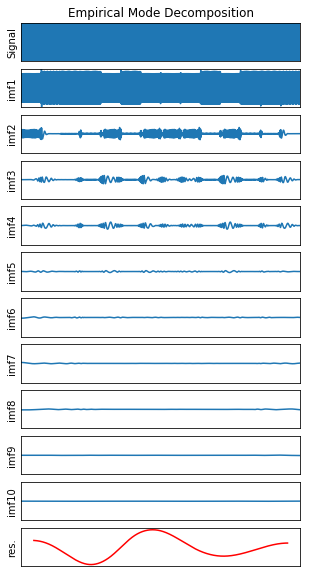

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

plot_imfs(x, imfs)

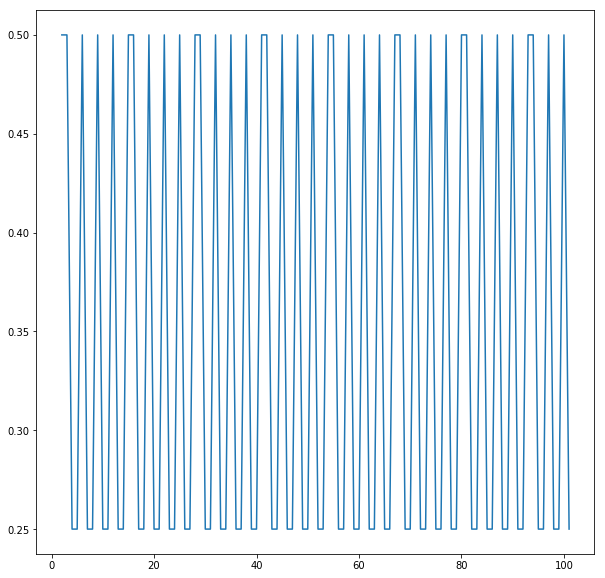

In [50]:
from pyhht.utils import inst_freq
rcParams['figure.figsize'] = 10, 10

instf, timestamps = inst_freq(x)
plt.plot(timestamps[:100], instf[:100])